# Suite des Tests

## Fichiers csv

In [1]:
import pandas as pd
#Importation du fichier csv
data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Premier jeux de données/Synergie/Synergie/Thomas Mckinlay_GS_15.11.24/Wednesday Alpine Skiing - GS at 10-20-detail.csv")

## Fonctions Global

In [2]:
import pyproj
def coordonnées_mercator(lat,long,elevation):
    transformer = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    'EPSG:25835',
    )
    x ,y, z = transformer.transform(long,lat,elevation,radians = False)
    return x,y,z

## Graphique de l'altitude et de la vitesse en fonction du temps

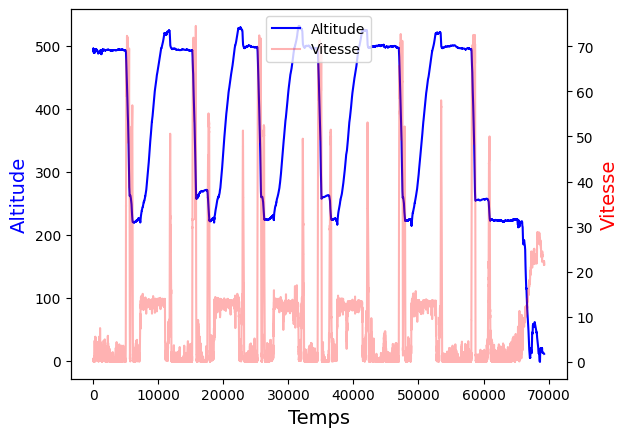

In [3]:
import matplotlib.pyplot as plt
#Graphique de l'atitude en focntion du temps
fig, ax = plt.subplots()
ax.plot(data['elevation[m]'][0:-1],"b")
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Altitude", color="blue", fontsize=14)
ax2 = ax.twinx()
ax2.plot(data['speed[km/h]'][0:-1],"r", alpha=0.3)
ax2.set_ylabel("Vitesse", color="red", fontsize=14)

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ["Altitude", "Vitesse"], loc="upper center")

#plt.plot(data['elevation[m]'][0:-1])
#plt.plot(data['speed[km/h]'][0:-1]*7)
plt.show()

## Méthode de calcule du nombre de descentes avec scipy

In [4]:
import numpy as np
from scipy.signal import argrelmin,argrelmax

index_min_locaux=argrelmin(data['elevation[m]'].to_numpy(), order=4000)[0]
index_max_locaux=argrelmax(data['elevation[m]'].to_numpy(), order=4000)[0]
min_locaux=np.median(np.array([data['elevation[m]'][i] for i in index_min_locaux]))
max_locaux=np.median(np.array([data['elevation[m]'][i] for i in index_max_locaux]))


#On prend l'altitude max moins un delta de x mètres pour déterminer le début de la descente et on regarde combien de fois le skieur quitte cette zone
alt_max_zone=max_locaux-(max_locaux-min_locaux)/4
alt_min_zone=min_locaux+(max_locaux-min_locaux)/4

data_dans_les_zones_départ_et_arrivée=data[(data['elevation[m]']>alt_max_zone) | (data['elevation[m]']<alt_min_zone)]
L=np.diff(data_dans_les_zones_départ_et_arrivée['elevation[m]'].to_numpy())
zone_de_descente_large=[data_dans_les_zones_départ_et_arrivée[i:i+2].index for i in range(len(L)) if L[i]<-10 ]
#Détection du départ et de l'arrivée
data_vitesse=data['speed[km/h]']
Liste_départ_arrivé_index=[]
vitesse_seuil_bas=9
vitesse_seuil_haut=5



#Initialisation
#detection debut
index=zone_de_descente_large[0][0]
index_debut=zone_de_descente_large[0][0]
vitesse=10
while vitesse >vitesse_seuil_haut and index!=0:
        if data_vitesse[index]<vitesse:
            vitesse=data_vitesse[index]
            index_debut=index
        index=index-1
#detection fin
index=zone_de_descente_large[0][1]
index_fin=zone_de_descente_large[0][1]
vitesse=10
while vitesse >vitesse_seuil_bas and index<zone_de_descente_large[0+1][1]:
        if data_vitesse[index]<vitesse:
            vitesse=data_vitesse[index]
            index_fin=index
        index=index+1
Liste_départ_arrivé_index.append([index_debut,index_fin])

#Recurrence
#Détéction début
for i in range(1,len(zone_de_descente_large)-1):
    vitesse=10
    index=zone_de_descente_large[i][0]
    index_debut=zone_de_descente_large[i][0]
    while vitesse >vitesse_seuil_haut and index>zone_de_descente_large[i-1][1]:
        if data_vitesse[index]<vitesse:
            vitesse=data_vitesse[index]
            index_debut=index
        index=index-1
    #detection fin
    index=zone_de_descente_large[i][1]
    index_fin=zone_de_descente_large[i][1]
    vitesse=10
    while vitesse >vitesse_seuil_bas and index<zone_de_descente_large[i+1][1]:
            if data_vitesse[index]<vitesse:
                vitesse=data_vitesse[index]
                index_fin=index
            index=index+1
    Liste_départ_arrivé_index.append([index_debut,index_fin])
#fin
#Détéction début
vitesse=10
index=zone_de_descente_large[i+1][0]
index_debut=zone_de_descente_large[i+1][0]
while vitesse >vitesse_seuil_haut and index>zone_de_descente_large[i][1]:
    if data_vitesse[index]<vitesse:
        vitesse=data_vitesse[index]
        index_debut=index
    index=index-1
#detection fin
index=zone_de_descente_large[i+1][1]
index_fin=zone_de_descente_large[i+1][1]
vitesse=10
while vitesse >vitesse_seuil_bas and index<len(data_vitesse):
        if data_vitesse[index]<vitesse:
            vitesse=data_vitesse[index]
            index_fin=index
        index=index+1
Liste_départ_arrivé_index.append([index_debut,index_fin])


## Visualisation des virages

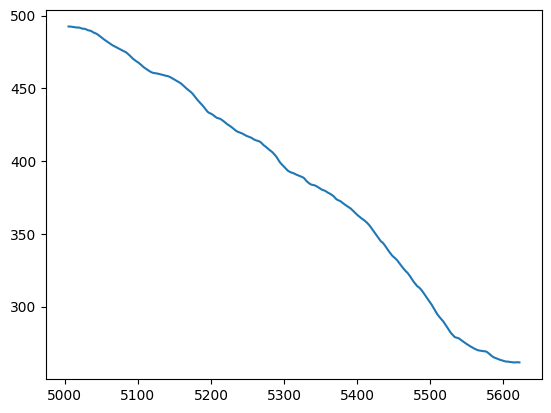

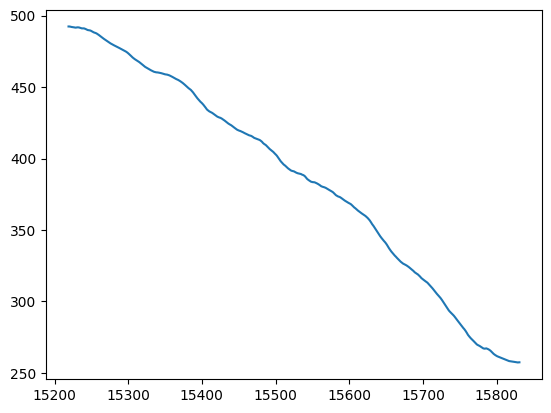

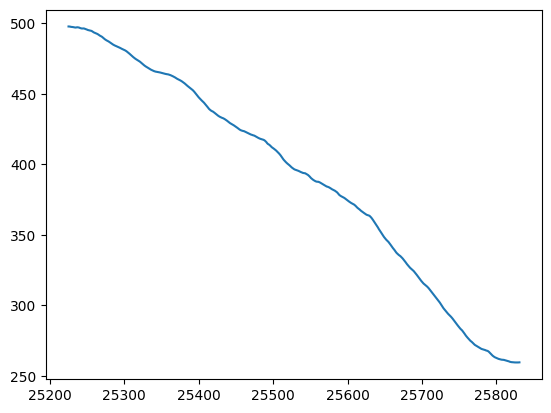

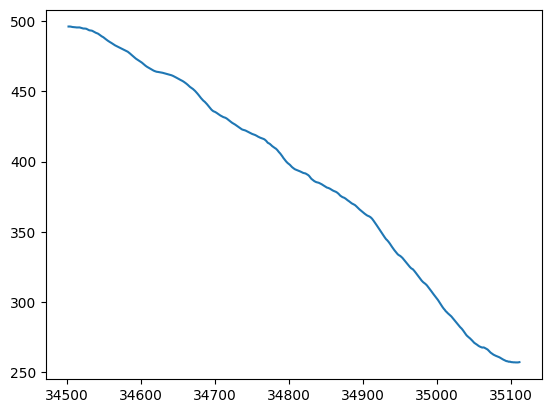

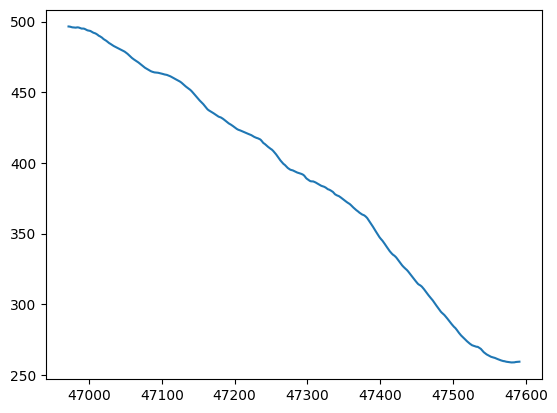

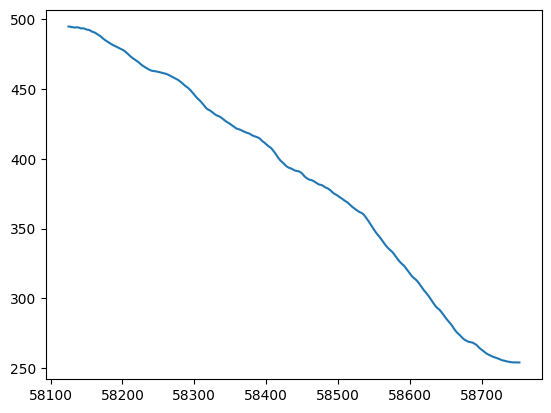

In [21]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import interactive
import plotly.graph_objects as go
from plotly.subplots import make_subplots

projection_mercator=coordonnées_mercator(data['Latitude[deg]'],data['Longitude[deg]'],data['elevation[m]'])


for i in range(len(Liste_départ_arrivé_index)) :
    plt.plot(data['elevation[m]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]])
    plt.show()
    vitesse=data['speed[km/h]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]]
    fig = make_subplots(
    rows=1, cols=1,specs=[[{'type': 'scene'}]])
    #Afficher la color bar pour la vitesse
    
    fig.add_trace(go.Scatter3d(x=projection_mercator[0][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]], y=projection_mercator[1][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]], z=projection_mercator[2][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]], mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8,colorbar=dict(title="Vitesse (km/h)")),name='Vitesse'))
    fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z'))
    fig.show()


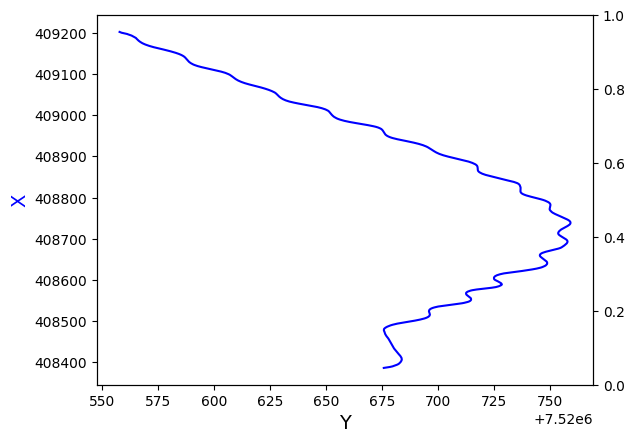

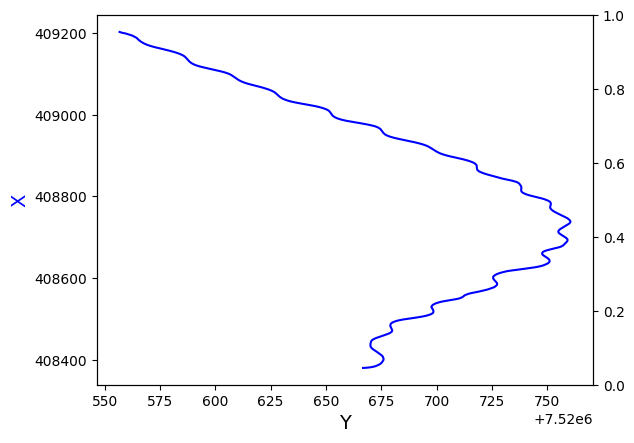

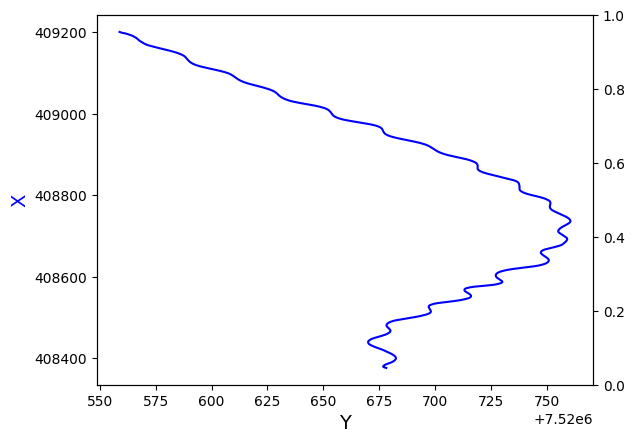

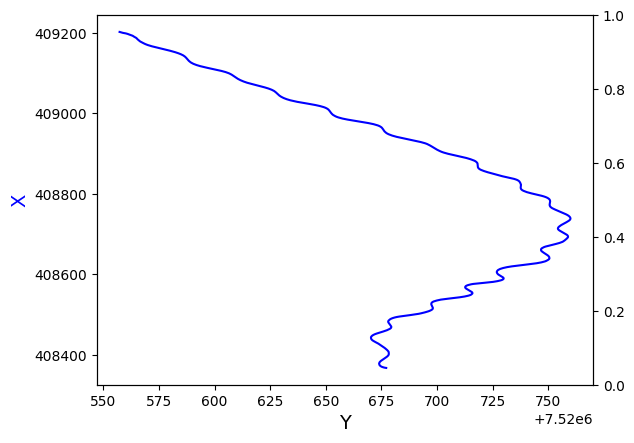

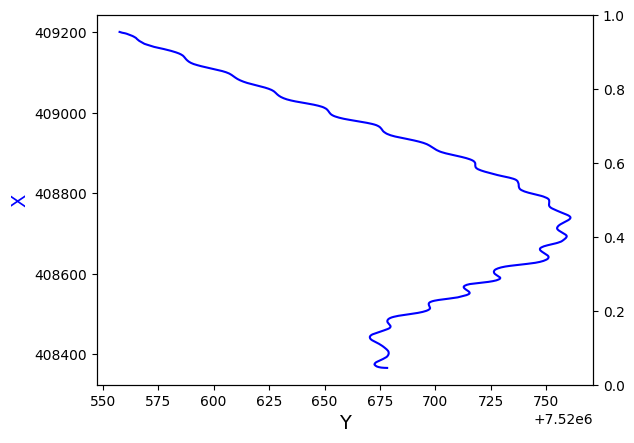

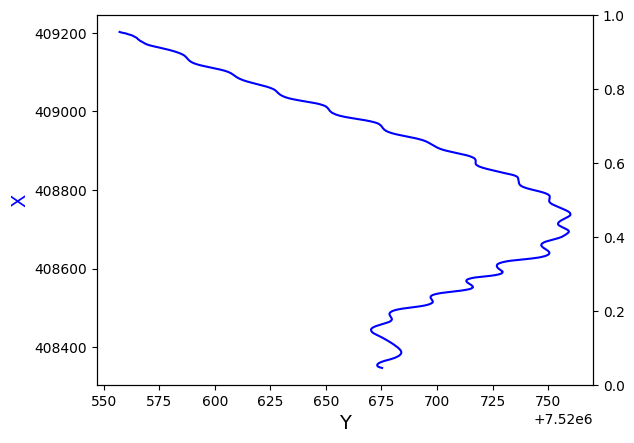

In [6]:
#Graphique en 2 dimensions projection mercator
for i in range(len(Liste_départ_arrivé_index)) :
    fig, ax = plt.subplots()
    
    

    ax.plot(projection_mercator[1][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]],projection_mercator[0][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]],"b")
    ax.set_xlabel("Y", fontsize=14)
    ax.set_ylabel("X", color="blue", fontsize=14)
    ax2 = ax.twinx()
    plt.show()

## Checkpoints

In [7]:
#fonction convertie longitude et latitude en coordonnées cartésiennes
import numpy as np

#L'intersection se fait avec l'index-1    
def intersection(x1,y1,z1,x2,y2,z2,n,p):
    #t1=time.time()
    X1=np.array([x1,y1,z1])
    X2=np.array([x2,y2,z2])
    #print("temps pour les coordonnées",time.time()-t1)
    if np.sign(np.dot(X1-p,n)) != np.sign(np.dot(X2-p,n)):
        return True
    else:
        return False

def resolution_plan_droite(n,p,X1,X2):
    a=n[0]
    b=n[1]
    c=n[2]
    d=-a*p[0]-b*p[1]-c*p[2]
    A=np.array([a,b,c,d])
    X1=np.array(np.append(X1,1))
    X2=np.array(np.append(X2,1))
    if np.dot(A,(X2-X1))==0:
        print(X1,X2)
        print(X2-X1)
        print('Erreur')
    t=-np.dot(A,X1)/np.dot(A,(X2-X1))
    return t

def estimation_temps(index,numéro_segment,p,n):
    X1=coordonnées_mercator(data['Latitude[deg]'][index-1],data['Longitude[deg]'][index-1],data['elevation[m]'][index-1])
    X2=coordonnées_mercator(data['Latitude[deg]'][index],data['Longitude[deg]'][index],data['elevation[m]'][index])

    Temps1=datetime.strptime(str(data['time[ISO-UTC]'][index-1]), '%Y%m%dT%H%M%S%f')
    temps2=datetime.strptime(str(data['time[ISO-UTC]'][index]), '%Y%m%dT%H%M%S%f')

    t=resolution_plan_droite(n[numéro_segment],p[numéro_segment],X1,X2)

    return Temps1+(temps2-Temps1)*t

def temps_entre_chaque_segment(temps_intermédiaires):
    temps=[]
    for i in range(len(temps_intermédiaires)-1):
        print((datetime.strptime(str(data['time[ISO-UTC]'][temps_intermédiaires[i+1]]), '%Y%m%dT%H%M%S%f')-datetime.strptime(str(data['time[ISO-UTC]'][temps_intermédiaires[i]]), '%Y%m%dT%H%M%S%f')).total_seconds())
        temps.append((datetime.strptime(str(data['time[ISO-UTC]'][temps_intermédiaires[i+1]]), '%Y%m%dT%H%M%S%f')-datetime.strptime(str(data['time[ISO-UTC]'][temps_intermédiaires[i]]), '%Y%m%dT%H%M%S%f')).total_seconds())
    return temps

In [8]:
#Mise en place des checkpoints en tout temps et des plans Pj

#Découpage de la descente en x segments
x=4
#Selection de la descente mère
index_debut=Liste_départ_arrivé_index[2][0]
index_fin=Liste_départ_arrivé_index[2][1]

#Point de départ
p0=np.array(coordonnées_mercator(data['Latitude[deg]'][index_debut],data['Longitude[deg]'][index_debut],data['elevation[m]'][index_debut]))
p0_prime=np.array(coordonnées_mercator(data['Latitude[deg]'][index_debut+1],data['Longitude[deg]'][index_debut+1],data['elevation[m]'][index_debut+1]))
n0=(p0_prime-p0)/np.linalg.norm(p0_prime-p0)

#Liste des points et des vecteurs normaux 
p=[]
n=[]
p.append(p0)
n.append(n0)

print(index_debut)
for i in range(1,x+1):
    index=index_debut+i*(index_fin-index_debut)//x
    print(index)
    p.append(np.array(coordonnées_mercator(data['Latitude[deg]'][index],data['Longitude[deg]'][index],data['elevation[m]'][index])))
    p_prime=np.array(coordonnées_mercator(data['Latitude[deg]'][index+1],data['Longitude[deg]'][index+1],data['elevation[m]'][index+1]))
    n.append((p_prime-p[-1])/np.linalg.norm(p_prime-p[-1]))
print(index_fin)

25225
25376
25528
25680
25832
25832


In [9]:
#---------------------------------------------------FINAL----------------------------------------------------------------------------------------------------------------

#Mise en place des temps intermédiaires entre chaque segments
import time
from datetime import datetime

index_debut=Liste_départ_arrivé_index[0][0]-50
index_fin=Liste_départ_arrivé_index[-1][1]+50
x,y,z =coordonnées_mercator(data['Latitude[deg]'][index_debut:index_fin],data['Longitude[deg]'][index_debut:index_fin],data['elevation[m]'][index_debut:index_fin])
temps_intermédiaires_descentes=[]
for descente in range(len(Liste_départ_arrivé_index)):
    index=Liste_départ_arrivé_index[descente][0]-40
    temps_intermédiaires=[]

    for i in range(len(n)):
        t2=time.time()
        #t1=time.time()
        while intersection(x[index-index_debut-1],y[index-index_debut-1],z[index-index_debut-1],x[index-index_debut],y[index-index_debut],z[index-index_debut],n[i],p[i])==False:
            #print("temps intersection",time.time()-t1)
            index=index+1
            #t1=time.time()
        #print(index)
        temps_intermédiaires.append(estimation_temps(index,i,p,n))
        #print("temps pour un checkpoint",time.time()-t2)

    #t3=time.time()
    temps_sections=[(temps_intermédiaires[i+1]-temps_intermédiaires[i]).total_seconds() for i in range(len(temps_intermédiaires)-1)]
    #t4=time.time()
    #print("temps sections",t4-t3)
    temps_intermédiaires_descentes.append(temps_sections)
print(temps_intermédiaires_descentes)

[[14.557471, 15.065943, 15.301411, 29.648439], [14.315035, 14.966469, 15.077698, 194.694158], [15.099, 15.2, 15.201, 15.2], [14.533559, 15.124517, 15.154333, 13.7217], [14.823154, 15.14331, 15.242178, 14.196765], [14.483096, 15.32855, 15.301669, 13.008329]]


In [38]:
import pyproj
#descente
j=2



fig = make_subplots(
    rows=1, cols=2,specs=[[{'type': 'scene'},{'type': 'scene'}]])

longeur_plan=20
for i in range(len(n)) :
        
    vecteur_colineaire=np.array([1,1,-1*(n[i][0]+n[i][1])/n[i][2]])
    vecteur_colineaire_2=np.array([0,1,-1*(n[i][1])/n[i][2]])
    vecteur_colineaire_3=np.array([1,0,-1*(n[i][0])/n[i][2]])

    angle=np.pi/2
    #matrice_de_rotation_par_rapport_a_n[i]
    matrice_de_rotation_par_rapport_a_N=np.array([[np.cos(angle)+n[i][0]**2*(1-np.cos(angle)),n[i][0]*n[i][1]*(1-np.cos(angle))-n[i][2]*np.sin(angle),n[i][0]*n[i][2]*(1-np.cos(angle))+n[i][1]*np.sin(angle)],[n[i][1]*n[i][0]*(1-np.cos(angle))+n[i][2]*np.sin(angle),np.cos(angle)+n[i][1]**2*(1-np.cos(angle)),n[i][1]*n[i][2]*(1-np.cos(angle))-n[i][0]*np.sin(angle)],[n[i][2]*n[i][0]*(1-np.cos(angle))-n[i][1]*np.sin(angle),n[i][2]*n[i][1]*(1-np.cos(angle))+n[i][0]*np.sin(angle),np.cos(angle)+n[i][2]**2*(1-np.cos(angle))]])
    vecteur_colineaire_4=np.dot(matrice_de_rotation_par_rapport_a_N,vecteur_colineaire)

    vecteur_colineaire=vecteur_colineaire/np.linalg.norm(vecteur_colineaire)
    vecteur_colineaire_2=vecteur_colineaire_2/np.linalg.norm(vecteur_colineaire_2)
    vecteur_colineaire_3=vecteur_colineaire_3/np.linalg.norm(vecteur_colineaire_3)
    vecteur_colineaire_4=vecteur_colineaire_4/np.linalg.norm(vecteur_colineaire_4)

    #print(np.dot(vecteur_colineaire,n[i]))
    #print(np.dot(vecteur_colineaire_2,n[i]))
    #print(np.dot(vecteur_colineaire_3,n[i]))
    #print(np.dot(vecteur_colineaire_4,n[i]))


    point_1=p[i]+longeur_plan*vecteur_colineaire
    point_2=p[i]-longeur_plan*vecteur_colineaire
    point_3=p[i]+longeur_plan*vecteur_colineaire_4
    point_4=p[i]-longeur_plan*vecteur_colineaire_4

    x = [point_1[0], point_2[0],point_3[0],point_4[0]]
    y = [point_1[1], point_2[1],point_3[1],point_4[1]]
    z = [point_1[2], point_2[2],point_3[2],point_4[2]]

    fig.add_trace(go.Mesh3d(x=x, y=y, z=z,),row=1, col=2)

    point_1=p[i]+longeur_plan*vecteur_colineaire
    point_2=p[i]-longeur_plan*vecteur_colineaire
    point_3=p[i]+longeur_plan*vecteur_colineaire_3
    point_4=p[i]-longeur_plan*vecteur_colineaire_3

    x = [point_1[0], point_2[0],point_3[0],point_4[0]]
    y = [point_1[1], point_2[1],point_3[1],point_4[1]]
    z = [point_1[2], point_2[2],point_3[2],point_4[2]]
    
    #fig.add_trace(go.Mesh3d(x=x, y=y, z=z,),row=1, col=1)



vitesse=data['speed[km/h]'][Liste_départ_arrivé_index[j][0]:Liste_départ_arrivé_index[j][1]]
Lat=data['Latitude[deg]'][Liste_départ_arrivé_index[j][0]:Liste_départ_arrivé_index[j][1]].to_numpy()
Long=data['Longitude[deg]'][Liste_départ_arrivé_index[j][0]:Liste_départ_arrivé_index[j][1]].to_numpy()
elevation=data['elevation[m]'][Liste_départ_arrivé_index[j][0]:Liste_départ_arrivé_index[j][1]].to_numpy()


x ,y, z = coordonnées_mercator(Lat,Long,elevation)


fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8)),row=1, col=1)
fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8)),row=1, col=2)
camera = dict(
    eye=dict(x=1.25, y=1.25, z=1.25)
)

scene = dict(
        xaxis = dict(nticks=10, range=[x.min()-50*(x.max()-x.min()),x.max()+0.10*(x.max()-x.min())],),
        yaxis = dict(nticks=10, range=[y.min()-0.50*(y.max()-y.min()),y.max()+0.10*(y.max()-y.min())],),
        zaxis = dict(nticks=10, range=[z.min(),z.max()],),
        )

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=600,
    width=1000,
    scene=scene,

)
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z'),scene2=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z'))

fig.show()

In [37]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


fig = make_subplots(
    rows=(len(Liste_départ_arrivé_index)-1)//3+1, cols=3,specs=[[{'type': 'scene'}]*3]*((len(Liste_départ_arrivé_index)-1)//3+1))

longeur_plan=20


for i in range(len(n)) :
        
    vecteur_colineaire=np.array([1,1,-1*(n[i][0]+n[i][1])/n[i][2]])
    vecteur_colineaire_2=np.array([0,1,-1*(n[i][1])/n[i][2]])
    vecteur_colineaire_3=np.array([1,0,-1*(n[i][0])/n[i][2]])

    angle=np.pi/2
    #matrice_de_rotation_par_rapport_a_n[i]
    matrice_de_rotation_par_rapport_a_N=np.array([[np.cos(angle)+n[i][0]**2*(1-np.cos(angle)),n[i][0]*n[i][1]*(1-np.cos(angle))-n[i][2]*np.sin(angle),n[i][0]*n[i][2]*(1-np.cos(angle))+n[i][1]*np.sin(angle)],[n[i][1]*n[i][0]*(1-np.cos(angle))+n[i][2]*np.sin(angle),np.cos(angle)+n[i][1]**2*(1-np.cos(angle)),n[i][1]*n[i][2]*(1-np.cos(angle))-n[i][0]*np.sin(angle)],[n[i][2]*n[i][0]*(1-np.cos(angle))-n[i][1]*np.sin(angle),n[i][2]*n[i][1]*(1-np.cos(angle))+n[i][0]*np.sin(angle),np.cos(angle)+n[i][2]**2*(1-np.cos(angle))]])
    vecteur_colineaire_4=np.dot(matrice_de_rotation_par_rapport_a_N,vecteur_colineaire)

    vecteur_colineaire=vecteur_colineaire/np.linalg.norm(vecteur_colineaire)
    vecteur_colineaire_2=vecteur_colineaire_2/np.linalg.norm(vecteur_colineaire_2)
    vecteur_colineaire_3=vecteur_colineaire_3/np.linalg.norm(vecteur_colineaire_3)
    vecteur_colineaire_4=vecteur_colineaire_4/np.linalg.norm(vecteur_colineaire_4)

    point_1=p[i]+longeur_plan*vecteur_colineaire
    point_2=p[i]-longeur_plan*vecteur_colineaire
    point_3=p[i]+longeur_plan*vecteur_colineaire_4
    point_4=p[i]-longeur_plan*vecteur_colineaire_4

    x = [point_1[0], point_2[0],point_3[0],point_4[0]]
    y = [point_1[1], point_2[1],point_3[1],point_4[1]]
    z = [point_1[2], point_2[2],point_3[2],point_4[2]]
    for j in range(len(Liste_départ_arrivé_index)) :
        fig.add_trace(go.Mesh3d(x=x, y=y, z=z,),row=(j)//3+1, col=(j)%3+1)


for i in range(len(Liste_départ_arrivé_index)):
    # Read data from a csv
    vitesse=data['speed[km/h]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]]
    Lat=data['Latitude[deg]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]].to_numpy()
    Long=data['Longitude[deg]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]].to_numpy()
    elevation=data['elevation[m]'][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]].to_numpy()


    x ,y, z = coordonnées_mercator(Lat,Long,elevation)
    fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8)),row=(i)//3+1, col=(i)%3+1)

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=600,
    width=1000
)
fig.show()


## Visualisation des vitesses et des puissances

In [12]:
from datetime import datetime

#Puissance = delta_t/delta_h j+1-j
Puissance=[]
Elevation=[]
Elevation_vitesse=[]
Vitesse=[]
for i in range(len(Liste_départ_arrivé_index)) :
    puissance=[]
    elevation=[]
    vitesse=[]
    elevation_vitesse=[]
    for j in range(Liste_départ_arrivé_index[i][0]+1,Liste_départ_arrivé_index[i][1]+1):
        vitesse.append(data['speed[km/h]'][j])
        elevation_vitesse.append(data['elevation[m]'][j])
        delta_t=(datetime.strptime(str(data['time[ISO-UTC]'][j]), '%Y%m%dT%H%M%S%f')-datetime.strptime(str(data['time[ISO-UTC]'][j-1]), '%Y%m%dT%H%M%S%f')).total_seconds()
        delta_h=data['elevation[m]'][j-1]-data['elevation[m]'][j]
        if delta_h!=0:
            puissance.append(delta_t/(delta_h))
            elevation.append(data['elevation[m]'][j])
    Puissance.append(puissance)
    Elevation.append(elevation)
    Vitesse.append(vitesse)
    Elevation_vitesse.append(elevation_vitesse)

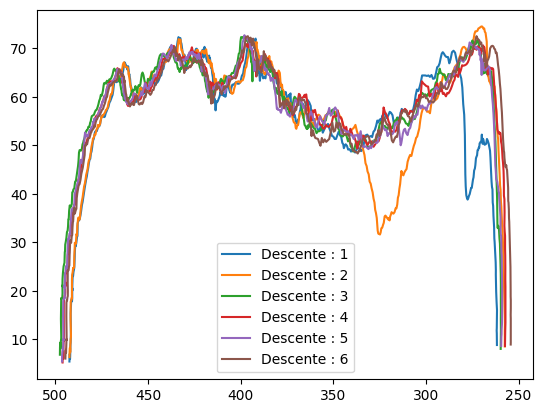

In [13]:
fig,axe = plt.subplots()
for i in range(len(Vitesse)):
    axe.plot(Elevation_vitesse[i],Vitesse[i],label=f'Descente : {i+1}')
    axe.xaxis.set_inverted(True)
    

plt.legend()
plt.show()

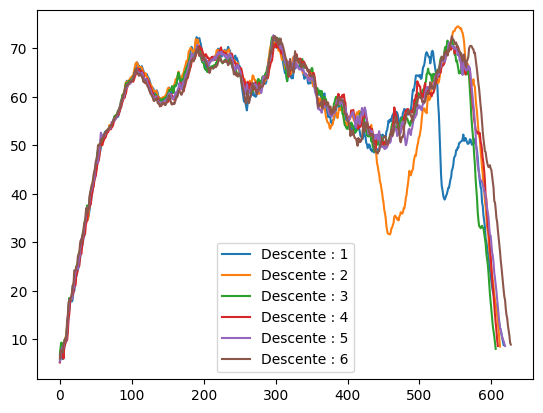

In [14]:
for i in range(len(Vitesse)):
    plt.plot(Vitesse[i],label=f'Descente : {i+1}')
   
plt.legend()
plt.show()